In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualizatio style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
sns.set_context("notebook", font_scale=1.2)

In [2]:
# Load the data
print("Loading employee data...")
data_dir = '../data/raw/'
employees_df = pd.read_csv(f'{data_dir}employees.csv', parse_dates=['HireDate', 'ExitDate'])

print(f"Dataset shape: {employees_df.shape}")
print(f"Number of employees: {len(employees_df)}")
print(f"Attrition rate: {employees_df['Attrition'].mean():.2%}")

# Display the first few rows
employees_df.head()

Loading employee data...
Dataset shape: (3892, 25)
Number of employees: 3892
Attrition rate: 22.92%


,EmployeeID,FirstName,LastName,Age,Gender,OfficeLocation,DistanceFromHome,Department,JobRole,JobLevel,...,JobSatisfaction,EnvironmentSatisfaction,WorkLifeBalance,PerformanceRating,Overtime,MonthlyIncome,AnnualIncome,TrainingTimesLastYear,Attrition,ExitDate
0,10001,Tuti,Hidayat,25,Male,Jakarta,12.41,Sales,Sales Representative,Entry Level,...,3.8,4,5,3,False,3.91,50.85,71,True,2025-01-26 07:38:40.440343
1,10002,Yanto,Purnama,46,Male,Jakarta,8.59,Sales,Branch Sales Supervisor,Senior,...,1.5,3,4,3,False,43.28,562.70,17,False,NaT
2,10003,Farida,Utama,39,Female,Surabaya,8.84,Customer Service,Customer Service Representative,Entry Level,...,3.0,3,4,3,False,5.33,69.24,22,False,NaT
3,10004,Dedi,Purnama,54,Male,Depok,15.93,Operations,Operations Supervisor,Senior,...,3.2,4,3,4,False,55.51,721.63,47,False,NaT
4,10005,Edi,Habibie,24,Female,Palembang,15.72,Operations,Regional Operations Director,Director,...,3.8,4,3,4,False,82.15,1068.00,10,False,NaT


#### Create time-based features

In [3]:
print("\n1. Creating time-based features...")
# Using the current date to calculate time-related features
current_date = datetime.now()
employees_df['HireDateObj'] = pd.to_datetime(employees_df['HireDate'])
employees_df['YearsSinceHire'] = (current_date - employees_df['HireDateObj']).dt.days / 365

# Calculate potential career progression rate
employees_df['TimeToPromotion'] = employees_df['YearsSinceLastPromotion'] / np.maximum(employees_df['YearsAtCompany'], 0.5)
# Clip extreme values
employees_df['TimeToPromotion'] = employees_df['TimeToPromotion'].clip(0, 1)



1. Creating time-based features...


#### Create salary-based features

In [4]:
print("\n2. Creating compensation-related features...")
# Salary ratio compared to job level median
employees_df['SalaryRatioToLevel'] = employees_df['MonthlyIncome'] / employees_df.groupby('JobLevel')['MonthlyIncome'].transform('median')

# Salary ratio compared to department median
employees_df['SalaryRatioDept'] = employees_df['MonthlyIncome'] / employees_df.groupby('Department')['MonthlyIncome'].transform('median')

# Salary ratio compared to similar tenure
tenure_bins = [0, 1, 3, 5, 10, 100]
employees_df['TenureGroup'] = pd.cut(employees_df['YearsAtCompany'], bins=tenure_bins, labels=False)
employees_df['SalaryRatioToTenure'] = employees_df['MonthlyIncome'] / employees_df.groupby('TenureGroup')['MonthlyIncome'].transform('median')


2. Creating compensation-related features...


#### Create commute difficulty categories

In [5]:
# Create commute difficulty categories
print("\n3. Creating commute difficulty categories...")
employees_df['CommuteDifficulty'] = pd.cut(
    employees_df['DistanceFromHome'], 
    bins=[0, 5, 15, 100], 
    labels=['Short', 'Medium', 'Long']
)


3. Creating commute difficulty categories...


#### Create work-life balance indicators

In [6]:
# Create work-life balance indicators
print("\n4. Creating work-life balance indicators...")
employees_df['WorkLifeImbalance'] = ((employees_df['WorkLifeBalance'] <= 2) & 
                                    (employees_df['Overtime'] == True)).astype(int)



4. Creating work-life balance indicators...


#### Create satisfaction composite scores

In [8]:
# Create satisfaction composite scores
print("\n5. Creating satisfaction composite scores...")
employees_df['OverallSatisfaction'] = (
    employees_df['JobSatisfaction'] + 
    employees_df['EnvironmentSatisfaction'] + 
    employees_df['WorkLifeBalance']
) / 3

# Create engagement score (combining satisfaction and performance)
employees_df['EngagementScore'] = (employees_df['OverallSatisfaction'] + employees_df['PerformanceRating'] / 5 * 5) / 2


5. Creating satisfaction composite scores...


#### Create career growth indicators

In [9]:
# Create career growth indicators
print("\n6. Creating career growth indicators...")
employees_df['StagnationRisk'] = ((employees_df['YearsSinceLastPromotion'] >= 2) & 
                                 (employees_df['YearsAtCompany'] > 3)).astype(int)

# Create career growth velocity
employees_df['CareerVelocity'] = employees_df['JobLevel'].map({
    'Entry Level': 1, 
    'Junior': 2, 
    'Mid-Level': 3, 
    'Senior': 4, 
    'Manager': 5, 
    'Director': 6, 
    'Executive': 7
}) / np.maximum(employees_df['YearsAtCompany'], 1)


6. Creating career growth indicators...


#### Create performance-related features


In [ ]:
# Create performance-related features
print("\n7. Creating performance-related features...")
# Higher performers often have different attrition patterns
employees_df['HighPerformer'] = (employees_df['PerformanceRating'] >= 4).astype(int)
employees_df['LowPerformer'] = (employees_df['PerformanceRating'] <= 2).astype(int)



7. Creating performance-related features...


#### Create income-to-age ratio (career progression indicator)

In [13]:
# Create income-to-age ratio (career progression indicator)
print("\n8. Creating career progression indicators...")
employees_df['IncomeToAgeRatio'] = employees_df['MonthlyIncome'] / employees_df['Age']


8. Creating career progression indicators...


#### Create training engagement indicator

In [14]:
# Create training engagement indicator
print("\n9. Creating training engagement indicators...")
employees_df['TrainingEngagement'] = pd.cut(
    employees_df['TrainingTimesLastYear'],
    bins=[-1, 20, 40, 100],
    labels=['Low', 'Medium', 'High']
)


9. Creating training engagement indicators...


#### Create education relevance indicator


In [15]:
# Create education relevance indicator
print("\n10. Creating education and demographic features...")
# Map education to numeric values for calculations
education_map = {
    'High School': 1,
    'Diploma': 2,
    'Bachelor\'s Degree': 3,
    'Master\'s Degree': 4,
    'PhD': 5
}
employees_df['EducationLevel'] = employees_df['Education'].map(education_map)

# Create age group categories
employees_df['AgeGroup'] = pd.cut(
    employees_df['Age'],
    bins=[20, 30, 40, 50, 100],
    labels=['20s', '30s', '40s', '50+']
)


10. Creating education and demographic features...


#### Post engineering

In [17]:
# Clean up by dropping intermediate columns
employees_df.drop(['HireDateObj', 'TenureGroup'], axis=1, inplace=True, errors='ignore')

In [18]:
# Print the new features
print("\nFeature engineering complete.")
print(f"Number of original features: {25}")  # Initial number of features
print(f"Number of new engineered features: {len(employees_df.columns) - 25}")
print(f"Total number of features: {len(employees_df.columns)}")


Feature engineering complete.
Number of original features: 25
Number of new engineered features: 17
Total number of features: 42


In [19]:
# Analyze the engineered features
engineered_features = [
    'YearsSinceHire', 'TimeToPromotion', 'SalaryRatioToLevel', 'SalaryRatioDept',
    'SalaryRatioToTenure', 'CommuteDifficulty', 'WorkLifeImbalance', 'OverallSatisfaction',
    'EngagementScore', 'StagnationRisk', 'CareerVelocity', 'HighPerformer',
    'LowPerformer', 'IncomeToAgeRatio', 'TrainingEngagement', 'EducationLevel', 'AgeGroup'
]

# Display summary statistics of new numeric features
numeric_engineered = [f for f in engineered_features if f not in ['CommuteDifficulty', 'TrainingEngagement', 'AgeGroup']]
print("\nSummary statistics for new numeric features:")
employees_df[numeric_engineered].describe()


Summary statistics for new numeric features:


,YearsSinceHire,TimeToPromotion,SalaryRatioToLevel,SalaryRatioDept,SalaryRatioToTenure,WorkLifeImbalance,OverallSatisfaction,EngagementScore,StagnationRisk,CareerVelocity,HighPerformer,LowPerformer,IncomeToAgeRatio,EducationLevel
count,3892.000000,3892.000000,3892.000000,3892.000000,3891.000000,3892.000000,3892.000000,3892.000000,3892.000000,3892.000000,3892.000000,3892.000000,3892.000000,3892.000000
mean,2.005903,0.422569,1.009258,1.258246,1.132842,0.226876,3.358573,3.229132,0.124872,2.115101,0.309866,0.206321,1.310580,2.568602
std,1.147740,0.391584,0.189735,1.398966,0.842701,0.418865,0.644540,0.552932,0.330616,1.508350,0.462498,0.404715,1.050737,0.874947
min,0.002740,0.000000,0.502527,0.069058,0.089563,0.000000,1.066667,1.250000,0.000000,0.250627,0.000000,0.000000,0.073654,1.000000
25%,1.026712,0.000000,0.872164,0.556793,0.431846,0.000000,2.933333,2.833333,0.000000,1.000000,0.000000,0.000000,0.416870,2.000000
50%,1.993151,0.414938,1.000000,1.000000,1.000000,0.000000,3.333333,3.250000,0.000000,1.673640,0.000000,0.000000,1.097770,3.000000
75%,2.991781,0.787920,1.144060,1.496307,1.668508,0.000000,3.933333,3.633333,0.000000,3.000000,1.000000,0.000000,1.917947,3.000000
max,4.000000,1.000000,1.731408,20.139381,6.628398,1.000000,5.000000,5.000000,1.000000,7.000000,1.000000,1.000000,11.873478,5.000000


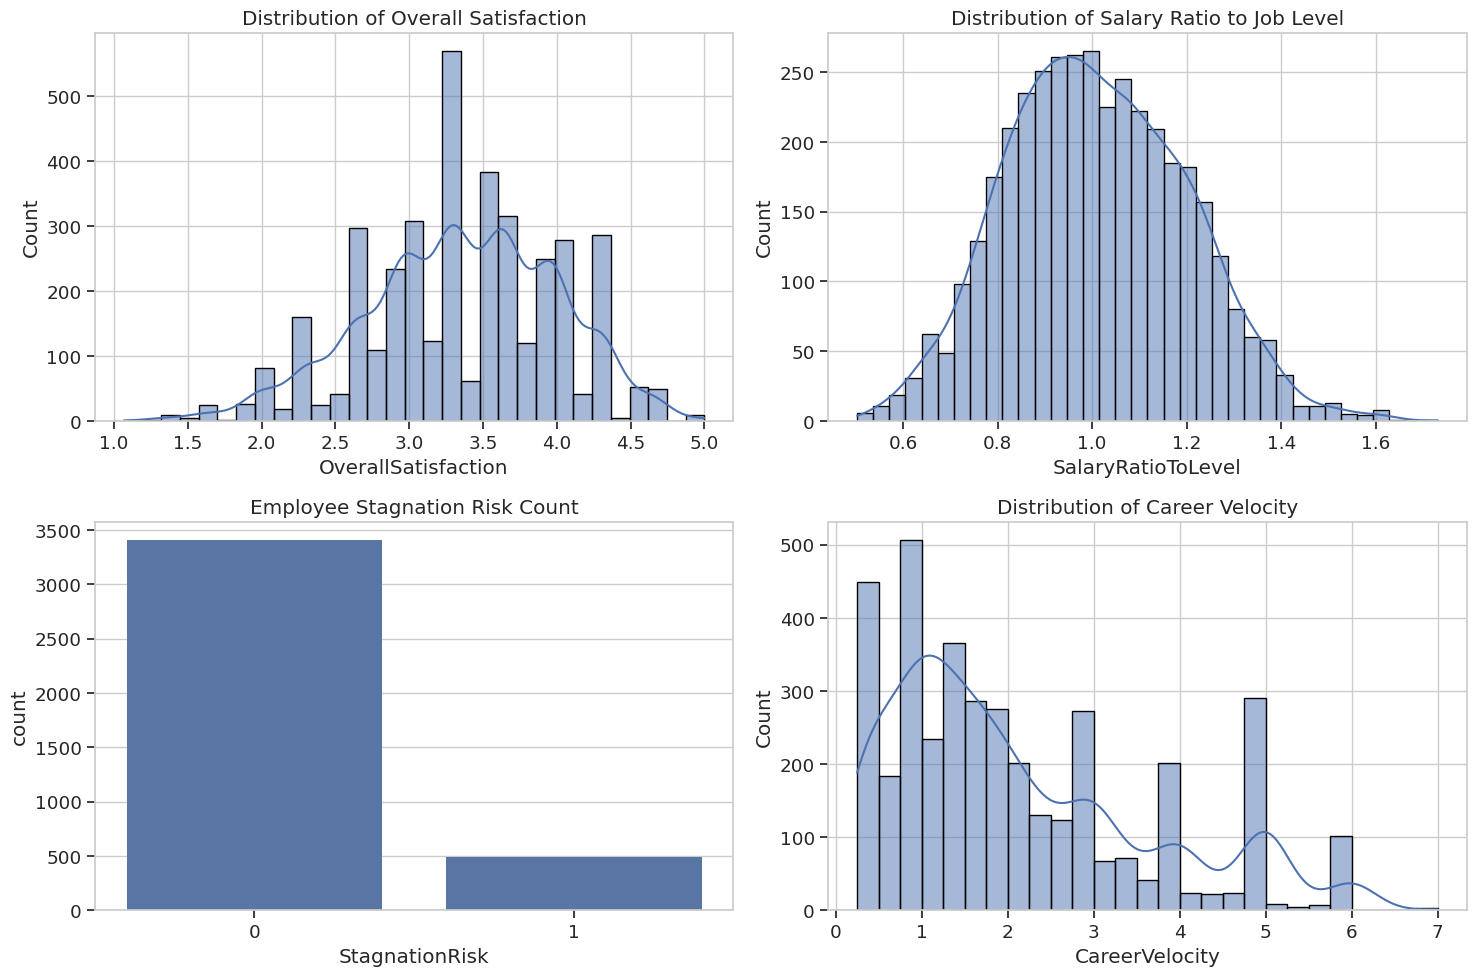

In [20]:
# Visualize distributions of a few key engineered features
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(employees_df['OverallSatisfaction'], kde=True)
plt.title('Distribution of Overall Satisfaction')

plt.subplot(2, 2, 2)
sns.histplot(employees_df['SalaryRatioToLevel'], kde=True)
plt.title('Distribution of Salary Ratio to Job Level')

plt.subplot(2, 2, 3)
sns.countplot(x='StagnationRisk', data=employees_df)
plt.title('Employee Stagnation Risk Count')

plt.subplot(2, 2, 4)
sns.histplot(employees_df['CareerVelocity'], kde=True)
plt.title('Distribution of Career Velocity')

plt.tight_layout()
plt.show()

In [21]:
# Save the engineered features to a new file
output_path = '../data/processed/employees_engineered.csv'
employees_df.to_csv(output_path, index=False)
print(f"\nEngineered features saved to: {output_path}")


Engineered features saved to: ../data/processed/employees_engineered.csv
